# Copy Number Variants

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [194]:
from keras.layers import Dense
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

In [195]:
data = pd.read_csv("final_data.csv")

Take the fist 10 columns as **input** and the last column (parameter `clinSign`) as **output**

In [196]:
input_columns = data.columns[0:10]
output_column = data.columns[-1]

Create the necessary array for input

In [197]:

def x_helper(row):
    return [row[i] for i in input_columns]

x_temp = data.apply(x_helper,axis=1)
y_temp = data[output_column]

res_data = pd.DataFrame(list(zip(x_temp,y_temp)),columns=("input","output"))

x = np.array(res_data['input'].tolist())
y = np.array(res_data['output'].tolist())

res_data.head()

,input,output
0,"[1.0, 1.0, 0.120410661, -0.40659957, 1.0, 1.0,...",1
1,"[1.0, 1.0, 0.00465053, -0.725674551, 1.0, 1.0,...",1
2,"[1.0, 1.0, 0.00465053, -0.725674551, 1.0, 1.0,...",1
3,"[1.0, 1.0, 0.003168344, 0.053668869, 1.0, 1.0,...",1
4,"[0.0, 1.0, 0.000149578, -0.642292587, 1.0, 1.0...",1


Counting zeros and ones for further balancing

In [198]:
ones = (y == 1).sum()
zeros = (y == 0).sum()
print("One's:", ones, "\nZero's:", zeros)

One's: 4612 
Zero's: 1967


Find all indices of ones and zeros

In [199]:
ones_indices = np.where(y == 1 )[0]
zeros_indices = np.where(y ==0)[0]

In [200]:
print(f"Counting zeros: {zeros}" )
print(f"Percentage of zeros: {zeros/(zeros+ones)}" )
print(f"Counting ones: {ones}" )
print(f"Percentage of ones: {ones/(zeros+ones)}" )

Counting zeros: 1967
Percentage of zeros: 0.2989816081471348
Counting ones: 4612
Percentage of ones: 0.7010183918528652


Create **balanced data** so that the number of ones and zeros is equal

In [201]:
n_samples = min(len(zeros_indices), len(ones_indices))

# Randomly select n_samples from ones and zeros
np.random.seed(42) 
selected_zeros_indices = np.random.choice(zeros_indices, n_samples, replace=False)
selected_ones_indices = np.random.choice(ones_indices, n_samples, replace=False)

# Combine and shuffle the indices
balanced_indices = np.concatenate([selected_zeros_indices, selected_ones_indices])
np.random.shuffle(balanced_indices)

# Create balanced arrays
x_balanced = x[balanced_indices]
y_balanced = y[balanced_indices]


In [202]:
ones = (y_balanced == 1).sum()
zeros = (y_balanced == 0).sum()
print("One's:", ones, "\nZero's:", zeros)

One's: 1967 
Zero's: 1967


Normalise the input data and separate the data for **training** and **testing**

In [203]:
# Scaling the features
mms = MinMaxScaler()
# test = x_balanced.copy()
x_balanced = mms.fit_transform(x_balanced)
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.25)

Create new output data arrays for model training and testing:

0 -> [1,0]

1 -> [0,1]

In [204]:

def y_helper(x):
    return [1 if x==i else 0 for i in range(2)]

y_train_array = np.array(list(map(y_helper,y_train)))
y_test_array = np.array(list(map(y_helper,y_test)))


In [205]:
# Compile the model
model = Sequential([
    Dense(16, input_dim=10, activation='relu'),
    Dense(64, activation='sigmoid'),
    Dense(16, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(loss=BinaryCrossentropy(), optimizer="adam", metrics=[BinaryAccuracy()])

In [206]:
history = model.fit(x_train, y_train_array, epochs=50, batch_size=32, validation_data=(x_test, y_test_array))


Epoch 1/50
93/93 [==============================] - 1s 4ms/step - loss: 0.6878 - binary_accuracy: 0.5515 - val_loss: 0.6815 - val_binary_accuracy: 0.5091
Epoch 2/50
93/93 [==============================] - 0s 3ms/step - loss: 0.6674 - binary_accuracy: 0.6098 - val_loss: 0.6549 - val_binary_accuracy: 0.6585
Epoch 3/50
93/93 [==============================] - 0s 3ms/step - loss: 0.6454 - binary_accuracy: 0.6520 - val_loss: 0.6497 - val_binary_accuracy: 0.6382
Epoch 4/50
93/93 [==============================] - 0s 2ms/step - loss: 0.6415 - binary_accuracy: 0.6537 - val_loss: 0.6462 - val_binary_accuracy: 0.6402
Epoch 5/50
93/93 [==============================] - 0s 3ms/step - loss: 0.6368 - binary_accuracy: 0.6576 - val_loss: 0.6442 - val_binary_accuracy: 0.6448
Epoch 6/50
93/93 [==============================] - 0s 3ms/step - loss: 0.6371 - binary_accuracy: 0.6595 - val_loss: 0.6428 - val_binary_accuracy: 0.6438
Epoch 7/50
93/93 [==============================] - 0s 3ms/step - loss: 0.63

## Testing the model

### Loss graph

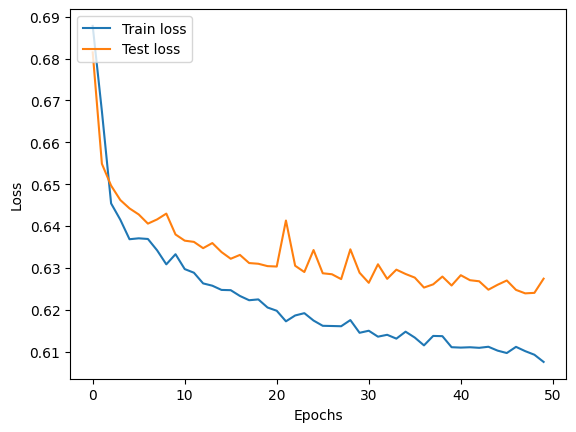

In [207]:
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["Train loss","Test loss"],loc='upper left')

plt.show()

### Accuracy graph

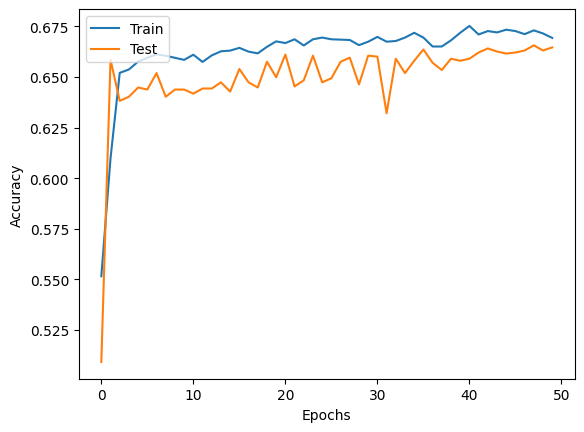

In [208]:
plt.plot(history.history['binary_accuracy'] )
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train',"Test"],loc='upper left')

plt.show()

In [209]:
# Evaluate the model on train data
loss, accuracy = model.evaluate(x_train, y_train_array)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")

93/93 [==============================] - 0s 2ms/step - loss: 0.6073 - binary_accuracy: 0.6773
Train Loss: 0.6073094606399536
Train Accuracy: 0.6772881150245667


In [210]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test_array)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

31/31 [==============================] - 0s 2ms/step - loss: 0.6274 - binary_accuracy: 0.6646
Test Loss: 0.6274300217628479
Test Accuracy: 0.6646341681480408


Making subarrays with zeros and ones

In [211]:
x_test_zeros = x_test[y_test == 0]
y_test_zeros = y_test_array[y_test == 0]

x_test_ones = x_test[y_test == 1]
y_test_ones = y_test_array[y_test == 1]

In [212]:
# Evaluate the model on the subset with zeros
loss_zeros, accuracy_zeros = model.evaluate(x_test_zeros, y_test_zeros)
print(f"Accuracy for test data with zeros: {accuracy_zeros}")

# Evaluate the model on the subset with ones
loss_ones, accuracy_ones = model.evaluate(x_test_ones, y_test_ones)
print(f"Accuracy for test data with ones: {accuracy_ones}")

16/16 [==============================] - 0s 2ms/step - loss: 0.5798 - binary_accuracy: 0.6915
Accuracy for test data with zeros: 0.6915113925933838
16/16 [==============================] - 0s 2ms/step - loss: 0.6734 - binary_accuracy: 0.6387
Accuracy for test data with ones: 0.6387225389480591
